In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20,
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

categories = ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy',
              'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',]

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='input', # Change to 'input'
    classes=categories
)

validation_generator = val_datagen.flow_from_directory(
    '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',
    target_size=(256, 256),
    batch_size=32,
    class_mode='input', # Change to 'input'
    classes=categories
)

Found 22243 images belonging to 12 classes.
Found 5559 images belonging to 12 classes.


In [4]:
# Encoder
input_img = Input(shape=(256, 256, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Create an EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Autoencoder
with tf.device('/device:GPU:0'):
    autoencoder.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])


Epoch 1/20
696/696 ━━━━━━━━━━━━━━━━━━━━ 420s 593ms/step - loss: 0.0078 - val_loss: 0.0034
Epoch 2/20
696/696 ━━━━━━━━━━━━━━━━━━━━ 320s 456ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 3/20
696/696 ━━━━━━━━━━━━━━━━━━━━ 307s 437ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 4/20
696/696 ━━━━━━━━━━━━━━━━━━━━ 304s 433ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 5/20
696/696 ━━━━━━━━━━━━━━━━━━━━ 304s 432ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 6/20
696/696 ━━━━━━━━━━━━━━━━━━━━ 314s 447ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 7/20
696/696 ━━━━━━━━━━━━━━━━━━━━ 333s 474ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 8/20
696/696 ━━━━━━━━━━━━━━━━━━━━ 350s 499ms/step - loss: 9.3624e-04 - val_loss: 0.0026
Epoch 9/20
696/696 ━━━━━━━━━━━━━━━━━━━━ 311s 443ms/step - loss: 9.0293e-04 - val_loss: 0.0023
Epoch 10/20
696/696 ━━━━━━━━━━━━━━━━━━━━ 334s 475ms/step - loss: 8.4377e-04 - val_loss: 0.0023
Epoch 11/20
696/696 ━━━━━━━━━━━━━━━━━━━━ 318s 451ms/step - loss: 8.0654e-04 - val_loss:

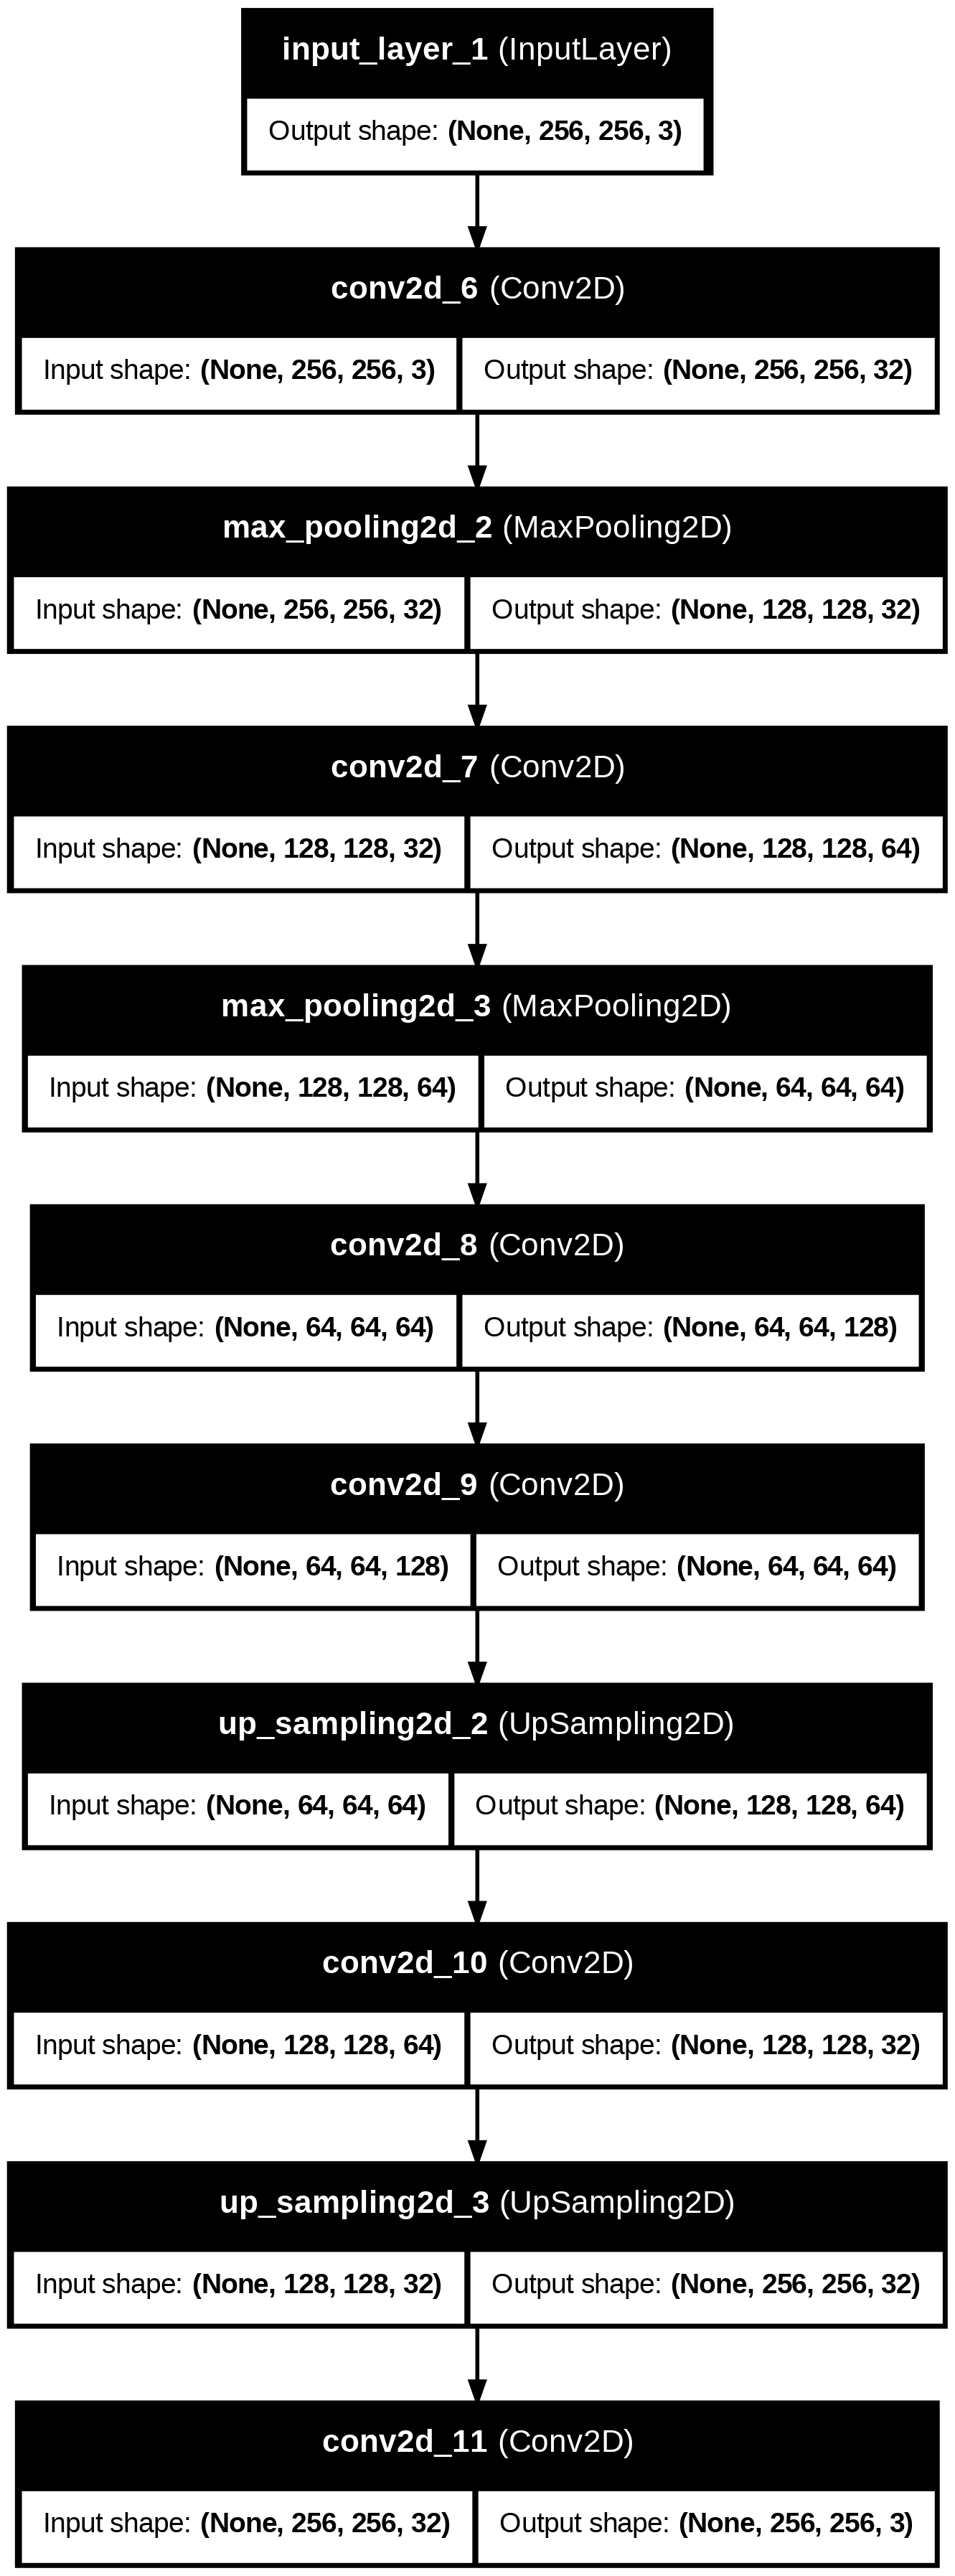

In [25]:
from tensorflow.keras.utils import plot_model

plot_model(autoencoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [5]:
autoencoder.save('autoencoder_model.h5')

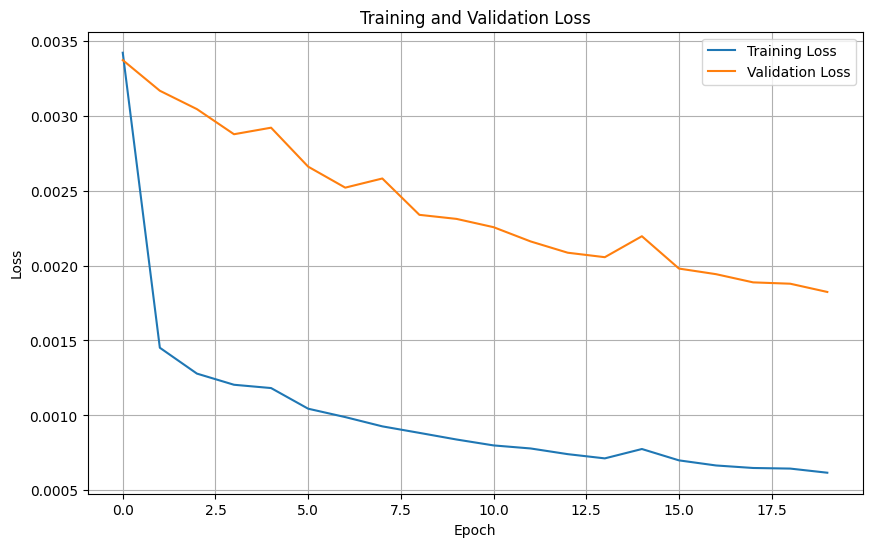

In [6]:

import matplotlib.pyplot as plt

# Access the training history from the autoencoder.fit() method
history = autoencoder.history.history

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import kagglehub

kagglehub.login()

# Replace with path to directory containing model files.
LOCAL_MODEL_DIR = '/kaggle/working/autoencoder_model.h5'

MODEL_SLUG = 'plant_detection_autoencoder' # Replace with model slug.

# Learn more about naming model variations at
# https://www.kaggle.com/docs/models#name-model.
VARIATION_SLUG = 'default' # Replace with variation slug.

kagglehub.model_upload(
  handle = f"brightadams/{MODEL_SLUG}/keras/{VARIATION_SLUG}",
  local_model_dir = LOCAL_MODEL_DIR,
  version_notes = 'Update 2024-12-22')

Uploading Model https://www.kaggle.com/models/brightadams/plant_detection_autoencoder/keras/default ...
Starting upload for file /kaggle/working/autoencoder_model.h5


Uploading: 100%|██████████| 2.29M/2.29M [00:01<00:00, 1.27MB/s]

Upload successful: /kaggle/working/autoencoder_model.h5 (2MB)


Your model instance version has been created.
Files are being processed...
See at: https://www.kaggle.com/models/brightadams/plant_detection_autoencoder/keras/default


In [11]:
import pickle
with open('./auto-encoder-history', 'wb') as file_pi:
    pickle.dump(autoencoder.history.history, file_pi)

In [7]:
# Paths
image_folder = '../input/ghana-crop-disease/images/'
train_csv_path = '../input/ghana-crop-disease/Train.csv'
test_csv_path = '../input/ghana-crop-disease/Test.csv'

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [9]:
# Load CSV data
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [ ]:
train_df.columns

In [11]:
classified=train_df['class'].value_counts()
classified

class
Corn_Cercospora_Leaf_Spot    6538
Tomato_Septoria              6483
Tomato_Late_Blight           3918
Corn_Streak                  3180
Tomato_Healthy               2872
Pepper_Septoria              2295
Pepper_Leaf_Mosaic           2113
Tomato_Early_Blight          1946
Pepper_Bacterial_Spot        1943
Corn_Common_Rust             1682
Corn_Healthy                 1571
Pepper_Leaf_Curl             1530
Tomato_Fusarium               882
Pepper_Healthy                736
Pepper_Late_Blight            575
Pepper_Leaf_Blight            508
Tomato_Bacterial_Spot         484
Pepper_Fusarium               472
Pepper_Cercospora             472
Tomato_Leaf_Curl              437
Corn_Northern_Leaf_Blight     157
Tomato_Mosaic                 134
Pepper_Early_Blight           101
Name: count, dtype: int64

In [10]:
# ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # Use a split if you have one combined DataFrame
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# ImageDataGenerator for validation (only rescaling)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Same split value as in the training generator
)

In [11]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_folder,
    x_col='Image_ID',
    y_col='class',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_folder,
    x_col='Image_ID',
    y_col='class',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 32824 validated image filenames belonging to 23 classes.
Found 8205 validated image filenames belonging to 23 classes.


In [14]:
import tensorflow as tf

# Assuming your autoencoder model is saved as 'autoencoder_model.h5'
autoencoder = tf.keras.models.load_model('/kaggle/input/plant_detection_autoencoder/keras/default/1/autoencoder_model.h5')

In [15]:
from tensorflow.keras.models import Model

encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[5].output)

In [16]:
from tensorflow.keras.layers import Flatten, Dense

# Get the output of the encoder part (assuming it's the 6th layer as before)
encoder_output = encoder_model.output

# Flatten the encoder output
x = Flatten()(encoder_output)
num_classes = len(train_generator.class_indices) # Get from the generator
output_layer = Dense(num_classes, activation='softmax')(x) # Example softmax for classification


# Create the new model
new_model = Model(inputs=encoder_model.input, outputs=output_layer)

# Compile the model (choose appropriate optimizer, loss, and metrics)
new_model.compile(optimizer=Adam(learning_rate=0.0001),  # Example optimizer
              loss='categorical_crossentropy', # Example loss for multi-class classification
              metrics=['accuracy'])

# Print model summary (optional)
new_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 524288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 23)                  │      12,058,647 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,151,895 (46.36 MB)

 Trainable params: 12,151,895 (46.36 MB)

 Non-trainable params: 0 (0.00 B)

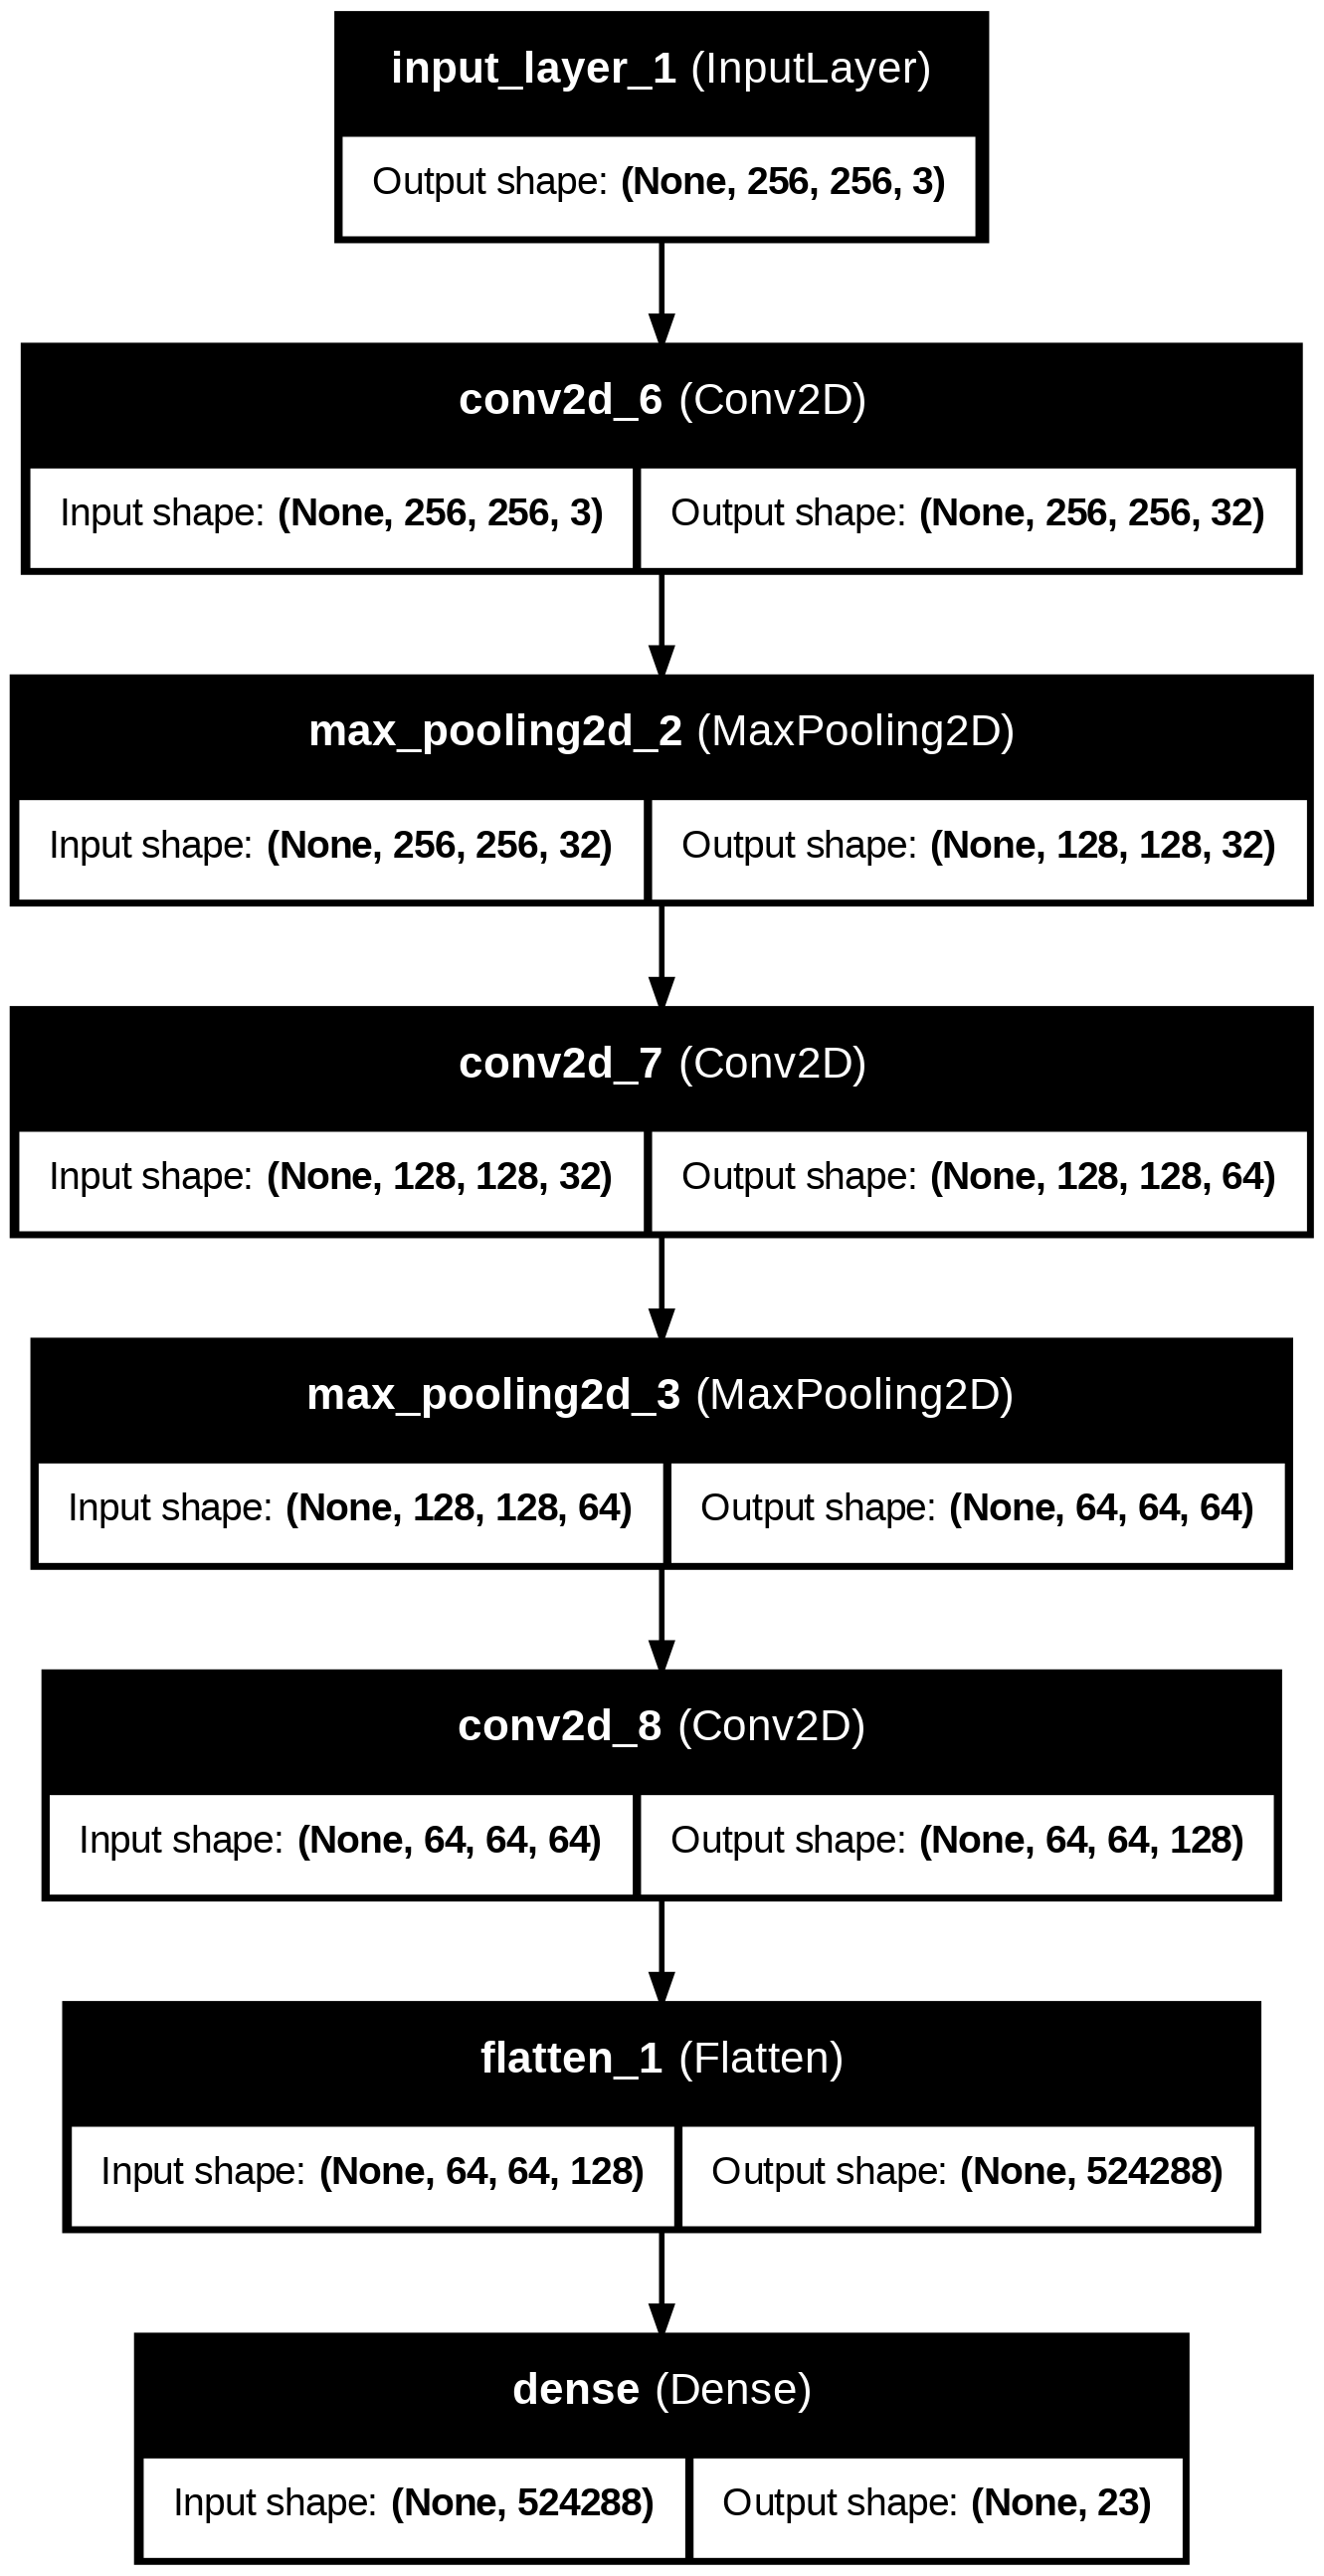

In [26]:
from tensorflow.keras.utils import plot_model

plot_model(new_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
checkpoint_filepath = 'model_checkpoint.keras'  # Path to save the checkpoint
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Save the entire model, not just weights
    monitor='val_accuracy',  # Monitor validation accuracy
    mode='max',  # Save the model when validation accuracy is maximum
    save_best_only=True  # Only save the best model
)

# ... (your existing code) ...


# Train the model with the checkpoint callback
with tf.device('/device:GPU:0'):
    history = new_model.fit(
      train_generator,
      epochs=10,  # Adjust the number of epochs as needed
      validation_data=validation_generator,
      callbacks=[model_checkpoint_callback]  # Add the callback to the fit function
    )

Epoch 1/10
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 3101s 2s/step - accuracy: 0.4120 - loss: 1.9553 - val_accuracy: 0.4920 - val_loss: 1.5967
Epoch 2/10
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 2827s 1s/step - accuracy: 0.5545 - loss: 1.3522 - val_accuracy: 0.5404 - val_loss: 1.4236
Epoch 3/10
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 2621s 1s/step - accuracy: 0.5918 - loss: 1.2196 - val_accuracy: 0.5519 - val_loss: 1.3414
Epoch 4/10
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 2687s 1s/step - accuracy: 0.6202 - loss: 1.1173 - val_accuracy: 0.5861 - val_loss: 1.3295
Epoch 5/10
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 2715s 1s/step - accuracy: 0.6367 - loss: 1.0438 - val_accuracy: 0.5921 - val_loss: 1.2662
Epoch 6/10
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 2677s 1s/step - accuracy: 0.6560 - loss: 0.9885 - val_accuracy: 0.6173 - val_loss: 1.2041
Epoch 7/10
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 2540s 1s/step - accuracy: 0.6746 - loss: 0.9415 - val_accuracy: 0.5906 - val_loss: 1.2580
Epoch 8/10
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 2685s 1s/step - accuracy: 0.6778 -

In [19]:
new_model.save('model_built_with_autoencoder.h5')

In [20]:
import kagglehub

kagglehub.login()

# Replace with path to directory containing model files.
LOCAL_MODEL_DIR = '/kaggle/working/model_built_with_autoencoder.h5'

MODEL_SLUG = 'model_built_with_autoencoder' # Replace with model slug.

# Learn more about naming model variations at
# https://www.kaggle.com/docs/models#name-model.
VARIATION_SLUG = 'default' # Replace with variation slug.

kagglehub.model_upload(
  handle = f"brightadams/{MODEL_SLUG}/keras/{VARIATION_SLUG}",
  local_model_dir = LOCAL_MODEL_DIR,
  version_notes = 'Update 2024-12-22')

Uploading Model https://www.kaggle.com/models/brightadams/model_built_with_autoencoder/keras/default ...
Model 'model_built_with_autoencoder' does not exist or access is forbidden for user 'brightadams'. Creating or handling Model...
Model 'model_built_with_autoencoder' Created.
Starting upload for file /kaggle/working/model_built_with_autoencoder.h5


Uploading: 100%|██████████| 146M/146M [00:02<00:00, 59.7MB/s] 

Upload successful: /kaggle/working/model_built_with_autoencoder.h5 (139MB)


Your model instance has been created.
Files are being processed...
See at: https://www.kaggle.com/models/brightadams/model_built_with_autoencoder/keras/default


In [21]:
import pickle
with open('./autoencoder_model', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

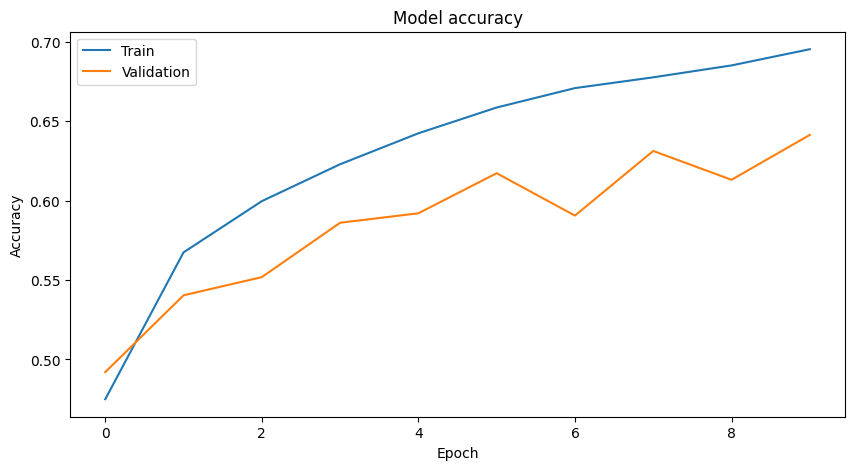

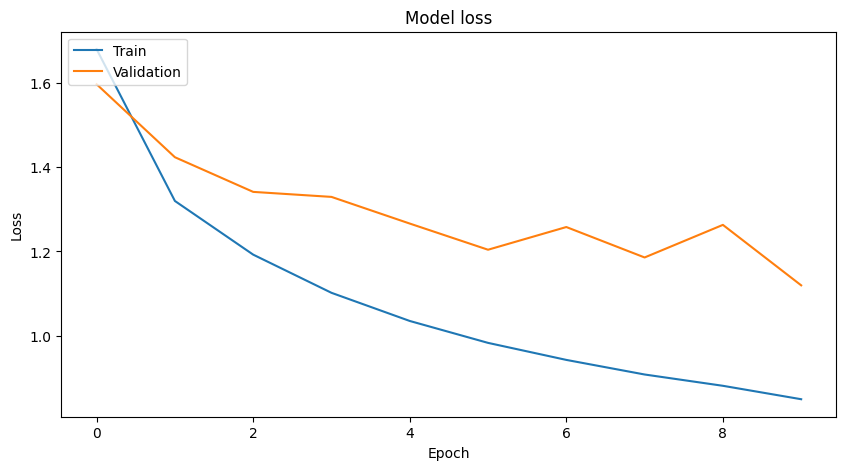

In [22]:
import matplotlib.pyplot as plt

# Assuming 'history' is available from your model training
# If not, load it from your saved training data.
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Use ResNet50 as the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the bas e model layers 
for layer in base_model.layers:
    layer.trainable = False

checkpoint_filepath = 'model_checkpoint.keras'  # Path to save the checkpoint
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Save the entire model, not just weights
    monitor='val_accuracy',  # Monitor validation accuracy
    mode='max',  # Save the model when validation accuracy is maximum
    save_best_only=True  # Only save the best model
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),  # Use a lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
with tf.device('/device:GPU:0'):
    history = model.fit(train_generator, epochs=10, validation_data=validation_generator,
      callbacks=[model_checkpoint_callback] )



Epoch 1/10
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 2827s 1s/step - accuracy: 0.2563 - loss: 2.5259 - val_accuracy: 0.2700 - val_loss: 2.3747
Epoch 2/10
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 2788s 1s/step - accuracy: 0.2890 - loss: 2.3362 - val_accuracy: 0.2949 - val_loss: 2.2781
Epoch 3/10
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 2607s 1s/step - accuracy: 0.3018 - loss: 2.2790 - val_accuracy: 0.3192 - val_loss: 2.2392
Epoch 4/10
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 2504s 1s/step - accuracy: 0.3153 - loss: 2.2192 - val_accuracy: 0.3231 - val_loss: 2.1709
Epoch 5/10
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 2560s 1s/step - accuracy: 0.3248 - loss: 2.1810 - val_accuracy: 0.3263 - val_loss: 2.1391
Epoch 6/10
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 2640s 1s/step - accuracy: 0.3308 - loss: 2.1385 - val_accuracy: 0.3486 - val_loss: 2.1235
Epoch 7/10
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 2647s 1s/step - accuracy: 0.3365 - loss: 2.1115 - val_accuracy: 0.3541 - val_loss: 2.0488
Epoch 8/10
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 2575s 1s/step - accuracy: 0.3479 -

In [14]:
model.save('./models/ghana_resnet_model.h5')

In [15]:
import kagglehub

kagglehub.login()

# Replace with path to directory containing model files.
LOCAL_MODEL_DIR = '/kaggle/working/models/ghana_resnet_model.h5'

MODEL_SLUG = 'plant_detection_resnet' # Replace with model slug.

# Learn more about naming model variations at
# https://www.kaggle.com/docs/models#name-model.
VARIATION_SLUG = 'default' # Replace with variation slug.

kagglehub.model_upload(
  handle = f"brightadams/{MODEL_SLUG}/keras/{VARIATION_SLUG}",
  local_model_dir = LOCAL_MODEL_DIR,
  version_notes = 'Update 2024-12-22')

Uploading Model https://www.kaggle.com/models/brightadams/plant_detection_resnet/keras/default ...
Model 'plant_detection_resnet' does not exist or access is forbidden for user 'brightadams'. Creating or handling Model...
Model 'plant_detection_resnet' Created.
Starting upload for file /kaggle/working/models/ghana_resnet_model.h5


Uploading: 100%|██████████| 120M/120M [00:03<00:00, 30.6MB/s] 

Upload successful: /kaggle/working/models/ghana_resnet_model.h5 (115MB)


Your model instance has been created.
Files are being processed...
See at: https://www.kaggle.com/models/brightadams/plant_detection_resnet/keras/default


In [16]:
import pickle
with open('./resnet_history', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

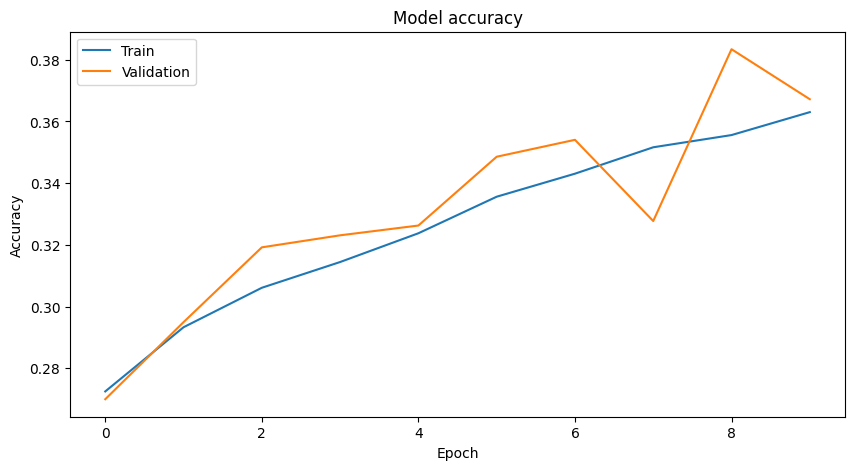

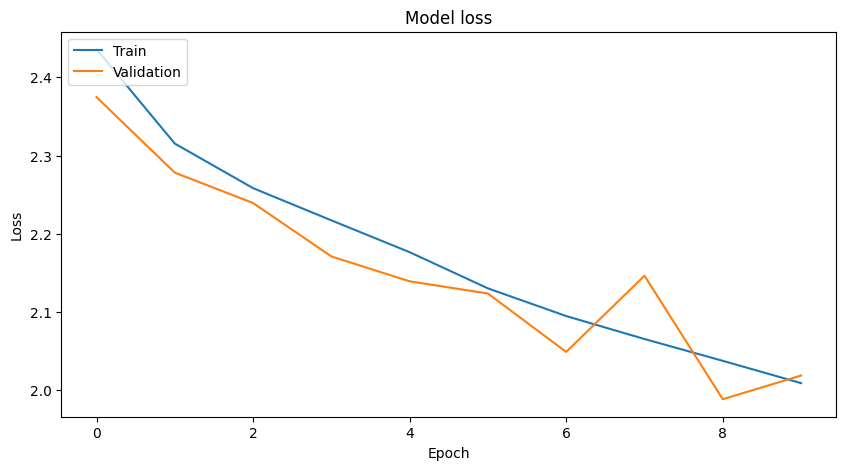

In [17]:
import matplotlib.pyplot as plt

# Assuming 'history' is available from your model training
# If not, load it from your saved training data.
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()